In [1]:
%run 'init.ipynb'
%run 'geometry_checks.ipynb'
%run 'functions.ipynb'

In [2]:
components = ["OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "OuterCryostatReflector",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "PmtTpc",
#              "Copper_TopRing",
#              "Teflon_Pillar_",
#              "SS_Electrodes",
#              "Teflon_BottomTPC",
#              "Teflon_TPC_Sliding",
#              "Teflon_TPC_Fixed",
#              "Copper_FieldGuard_",
#              "Copper_FieldShaperRing_",
#              "Copper_BottomPmtPlate"
             ]

isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226"
                ]


In [3]:
N = 100000000
m_fv = 4 #tons

In [4]:
def calculate_events(data, isotope):
    ss = single_scatter(data)
    fv_ = fv(ss)
    energy_ = energy(fv_, 1, 12)
    #en = select_typepri(energy_, isotope)
    #events_df = pd.DataFrame()
    #events_df = pd.concat([events_df, en])
    events_passing = len(energy_)
    if events_passing ==0:
        en_enlarged = energy(fv_, 1, 100)
        events_passing = (len(en_enlarged)*11)/99
        if events_passing == 0:
            events_passing = 2.3
    return events_passing

In [5]:
def add_var(data):
    data['rp'] = np.sqrt(data.xp**2+ data.yp**2)
    #data['r2p'] = data.rp*data.rp
    data['R'] = np.sqrt(data.X**2+ data.Y**2)
    #data['R2'] = (data.R*data.R)
    return data

def get_xyz(rootfile):
    dataframe = []
    for df in read_root(rootfile, "events/events", chunksize=1000000,
                             columns= ["xpri", "ypri", "zpri", "epri", "ns", "X", "Y", "Z", "Ed"],
                            where="ns==1"):#, unit = "chunks"):
        x_values=[x[0] for x in df.X]
        y_values=[y[0] for y in df.X]
        z_values=[z[0] for z in df.X]
        df["X"]=x_values
        df["Y"]=y_values
        df["Z"]=z_values
        dataframe.append(df)
    
    dataframe=pd.concat(dataframe)
    dataframe.columns = ['xp', 'yp', 'zp_uc', "epri", "ns", "X", "Y", "Z_uc", "Ed"] #rename 
    offset = 1488/2
    dataframe['rp'] = np.sqrt(dataframe.xp**2+ dataframe.yp**2)
    dataframe['r2p'] = dataframe.rp*dataframe.rp
    dataframe['R'] = np.sqrt(dataframe.X**2+ dataframe.Y**2)
    dataframe['R2'] = (dataframe.R*dataframe.R)
    dataframe['Z'] = dataframe.Z_uc+offset
    dataframe['zp'] = dataframe.zp_uc+ offset
    return dataframe



In [6]:
#material = "SS_AnodeRing"
#isotope = "Co60"
#rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
#rootfile2 = "/dali/lgrandi/xenonnt/simulations/er_simulations/final_files/SS_AnodeRing/U238/output_SS_AnodeRing_U238_FINAL_Sort.root"
#print(rootfile)
#data = get_xyz(rootfile)
#print(len(data))
#data_jp = add_var(data_jp)

#for isotope in isotope_array:
#    print(isotope)
#    data = get_data(isotope, "SS_Electrodes", 1000)
#    print("---------",len(data))


In [7]:
def get_data(isotope, component, N):
    df = pd.DataFrame()
    if component == "OuterCryostatShell":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat" 
        rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
        fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
        df = shell
        frac = fraction_shell
    elif component == "OuterCryostat_Elongation":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat"
        rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
        df = elongation
        fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
        frac = fraction_elong 
    elif component == "OuterCryostat_flanges":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat"
        rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
        flanges = pd.concat([flange1, flange2, flange3])
        df = flanges
        fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
        frac = fraction_flanges
    elif component == "SS_InnerCryostatShell":
        material = "SS_InnerCryostat" 
        rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
        df = shell_in
        frac = fraction_shell
    elif component == "SS_InnerCryostatFlanges":
        material = "SS_InnerCryostat" 
        rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
        df = flanges_in
        frac = fraction_flanges
    elif component == "SS_InnerCryostat_bottomDome":
        material = "SS_InnerCryostat" 
        rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
        flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
        fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
        frac = fraction_elong
        df = elongation_in
    elif component == "SS_BellSideWall":
        material = 'SS_BellSideWall'
        rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        bottomLip, bellWall = divide_bellWall(data)
        fraction_side, fraction_lip = bell_wall_numbers(N)
        frac = fraction_side
        df = bellWall
    elif component == "SS_BellSideWallBottomLip":
        material = 'SS_BellSideWall'
        rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        bottomLip, bellWall = divide_bellWall(data)
        df = bottomLip 
        fraction_side, fraction_lip = bell_wall_numbers(N)
        frac = fraction_lip
    #elif component == "SS_Electrodes":
    #    material = 'SS_AnodeRing'
    #    rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
    #    print(rootfile)
    #    data = get_xyz(rootfile)
    #    frac = 1
    elif component == "Top_PTFE_Frame":
        material = 'SS_Teflon_TopElectrodesFrame'
        rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        data = get_xyz(rootfile)
        frac = 1
    elif component ==  "Teflon_TPC_Sliding":
        DATE = "XENONnT_20191202"
        material = "Teflon_TPC"
        rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        df = get_xyz(rootfile)
        frac = 1
    elif component ==  "Teflon_TPC_Fixed":
        DATE = "XENONnT_20191202"
        material = "Teflon_TPC"
        rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        df = get_xyz(rootfile)
        frac = 1
    else:
        material = component
        rootfile = '/dali/lgrandi/xenonnt/simulations/er_simulations/final_files' + '/'+ material + '/' + isotope + '/' + 'output_'+ material + '_' + isotope +'_FINAL_Sort' + '.root'
        df = get_xyz(rootfile)
        frac = 1
    return df, frac

In [8]:
#data, fr = get_data("Co60", "SS_AnodeRing", 1000)
#data.head()
#print(len(data))

In [9]:
def do(component, m_fv): 
   
    conv = 3.15*1e7
    rate_array = []
    error_array = []
    i = 0
    flag = 0
    total_str = ""  
    E = 11
    time_array = []
    
    for i in range(0, len(isotope_array)):
        
        isotope = isotope_array[i]
        data, frac = get_data(isotope, component, N)
        
        #n = select_typepri(data, isotope)-------> in case other type pri function 
        b = select_typepri(data, isotope) #later on with the good function
        n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
        n_events = calculate_events(data, isotope)
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        err = "err_"+isotope
        err = str(err)
        error_cont = p[err]/1000 #mBq->Bq
        
        if (contamination == 0):
            rate = 0
            error_rate = 0
            str_ = ( "| no contamination value ")
            alpha = 0
            time = 0

        else:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
            rate = n_events/(time * m_fv ) #*E  #ev/s*t
            alpha = mass / (m_fv * n) #correct with mass*b/(m_fv*E*N_gen)  ##no energy  
            err = "err_"+isotope
            err = str(err) 
            error_rate = alpha * np.sqrt((n_events * error_cont)**2 + (contamination*np.sqrt(n_events))**2)
            if n_events == 2.3: 
                str_ = ("|<%4.4f" %(rate*conv))
                flag = flag +1
            else:
                str_ = ("|(%4.4f +- %4.4f)" %(rate*conv, error_rate*conv))
            
        rate_array = np.append(rate_array, rate)
        error_array = np.append(error_array, error_rate) 
        total_str = total_str  + str_ 
        
        if time == 0:
            time_array = time_array = np.append(time_array, time)  
        else:
            time_array = time_array = np.append(time_array, time/conv)
        
        i = i+1 
        tot_rate = 0
        tot_error_rate = 0
        if len(rate_array)!=0:
            for i in range(0, len(rate_array)):
                tot_rate = tot_rate + rate_array[i]
                tot_error_rate = tot_error_rate + error_array[i]
                if flag == 0:
                    total_rate_string = ("|(**%4.4f +- %4.4f)" %(tot_rate*conv, tot_error_rate*conv)+ "**|" )
                else:
                    total_rate_string = ("|**<%4.4f " %(tot_rate*conv)+ "**|") 
        else:
            total_rate_string = "|"        
    print("|" + component + total_str + total_rate_string)
    return tot_rate*conv, time_array
    
####################################################################################

In [12]:
isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                #"Ra226"
                ]

components = ["OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "OuterCryostatReflector",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "PmtTpc",
             "Teflon_Pillar_",
             "SS_AnodeRing",
             "Teflon_TPC_Sliding",
             "Teflon_TPC_Fixed",
#              "Teflon_BottomTPC",
#              "Copper_TopRing",
#              "Copper_FieldGuard_",
#              "Copper_FieldShaperRing_",
#              "Copper_BottomPmtPlate"
             ]
# dict_times = {
#         "isotope_string" : "U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Ra226"
#     }

isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                #"Ra226"
                ]

def print_results(m_fv):
    total_rate = []
    times = []
    print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[6], "^ Tot ^", )
    for component in components:
        tot_rate_per_comp, time = do(component, m_fv)
        total_rate = np.append(total_rate, tot_rate_per_comp)
#        dict_ = {component : time}
#        dict_times.update(dict_)
#     return dict_times
    print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

print_results(m_fv) 
# print(dict_times)

^material ^ U238 ^ Co60 ^ K40 ^ Cs137 ^ Th228 ^ U235 ^ Th232 ^ Th232 ^ Tot ^
|PmtTpc|(12.2543 +- 4.0705)|(6.3410 +- 1.7572)|(6.0595 +- 1.3445)|(0.3900 +- 0.2440)|(2.0919 +- 0.8266)|(1.7716 +- 0.5801)|(2.2772 +- 0.8968)|(**31.1854 +- 9.7196)**|
^Tot.^^^^^^^^^ 31.1854 ev/t*y^


In [39]:
components = ["OuterCryostat_Elongation",
             "OuterCryostatShell", ]
isotope_array = ["U238"]

from multiprocessing import Pool
num_processors = 3
p=Pool(processes = num_processors)


In [ ]:
###plot spectrum per component 
def plot_spectrum(data, min,max, bins, isotope, time):
    time_weights = [1/time]*len(data)
    plt.hist(data.Ed, bins = bins, range = (min, max), weights = time_weights, histtype = 'step', label = isotope)
    plt.ylabel('log(counts)')
    plt.xlabel('Ed [keV]')
    plt.yscale('log')
    plt.tight_layout()
    plt.legend()
    
for component in components:
    print("working on:" , component)
    for i in range(0, len(isotope_array)):
        isotope = isotope_array[i]
        data, frac = get_data(isotope, component, N)
        b = select_typepri(data, isotope) #later on with the good function
        n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
        p = get_parameters(component)
        mass = p['mass']
        contamination = p[isotope] 
        if contamination > 0:
            contamination = p[isotope]/1000 
            time = n / (mass * contamination)
        else:          
            print("no contamination")
        
        plot_spectrum(data, 0, 3500, 300, isotope, time) 
    plt.show()

In [ ]:
# plot spectrum per material 

def plot_total_contribution(bins, min_val, max_val ):
    conv = 3.15*1e7 #sec->year
    bins_ = bins 
    min_ = min_val
    max_ = max_val
    values = np.zeros(bins) 
    for component in components:
        print("working on:" , component)
        for i in range(0, len(isotope_array)):
            n =0
            isotope = isotope_array[i]
            data, frac = get_data(isotope, component, N)
            b = select_typepri(data, isotope) #later on with the good function
            n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
            p = get_parameters(component)
            mass = p['mass']
            contamination = p[isotope] 
            if contamination > 0:
                contamination = p[isotope]/1000 
                time = n / (mass * contamination)
            else:          
                print("no contamination for ", isotope)
            time_weights = [1/time]*len(data)
            n, bins_plt, _ = plt.hist(data.Ed, bins = bins_, range = (min_, max_), weights = time_weights, 
                                      histtype = "step", label = ("%s %s"%(component, isotope)))            
            #plt.yscale("log") 
            values = values+n 
    return values, bins_plt


values, bins_plt = plot_total_contribution(300, 0, 500 )
plt.plot(bins_plt[:-1], values, "black", label = "tot")
plt.legend(markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.yscale("log")
plt.ylabel("rate")

plt.xlabel("Energy [keV]")
plt.title("ER from materials")
plt.show() 


  0%|          | 0/14 [00:00<?, ?it/s]

working on: OuterCryostat_Elongation



  7%|▋         | 1/14 [00:58<12:44, 58.78s/it]

working on: OuterCryostatShell



 14%|█▍        | 2/14 [02:06<12:18, 61.53s/it]

working on: OuterCryostat_flanges



 21%|██▏       | 3/14 [02:56<10:37, 58.00s/it]

working on: SS_InnerCryostatShell



 29%|██▊       | 4/14 [05:50<15:29, 92.94s/it]

working on: SS_InnerCryostatFlanges



 36%|███▌      | 5/14 [07:54<15:20, 102.26s/it]

working on: SS_InnerCryostat_bottomDome



 43%|████▎     | 6/14 [09:25<13:10, 98.87s/it] 

working on: SS_BellPlate



 50%|█████     | 7/14 [16:16<22:26, 192.29s/it]

working on: SS_BellSideWall



 57%|█████▋    | 8/14 [18:06<16:46, 167.70s/it]

working on: SS_BellSideWallBottomLip



 64%|██████▍   | 9/14 [19:47<12:17, 147.58s/it]

working on: PmtTpc



 71%|███████▏  | 10/14 [25:50<14:09, 212.34s/it]

working on: Teflon_Pillar_
no contamination for  Co60



 79%|███████▊  | 11/14 [26:40<08:11, 163.70s/it]

working on: SS_AnodeRing



 86%|████████▌ | 12/14 [27:41<04:25, 132.75s/it]

working on: Teflon_TPC_Sliding
no contamination for  Co60



 93%|█████████▎| 13/14 [28:32<01:48, 108.15s/it]

working on: Teflon_TPC_Fixed
no contamination for  Co60



100%|██████████| 14/14 [29:11<00:00, 125.14s/it]


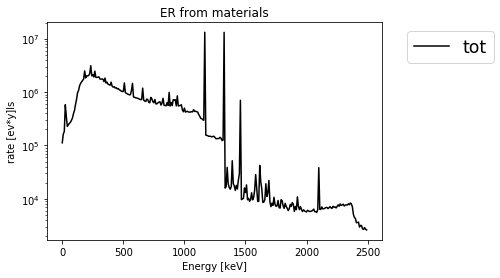

In [12]:
isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                #"Ra226"
                ]



components = ["OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             #"OuterCryostatReflector",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "PmtTpc",
             "Teflon_Pillar_",
             "SS_AnodeRing",
             "Teflon_TPC_Sliding",
             "Teflon_TPC_Fixed"]

def plot_total_contribution(bins, min_val, max_val ):

    bins_ = bins 
    min_ = min_val
    max_ = max_val
    values = np.zeros(bins) 
    for component in tqdm(components):
        print("working on:" , component)
        for i in range(0, len(isotope_array)):
            isotope = isotope_array[i]
            data, frac = get_data(isotope, component, N)
            b = select_typepri(data, isotope) #later on with the good function
            n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
            p = get_parameters(component)
            mass = p['mass']
            contamination = p[isotope] 
            if contamination > 0:
                contamination = p[isotope]/1000 
                time = n / (mass * contamination)
            else:          
                print("no contamination for ", isotope)
            time_weights = [1/time]*len(data)
            n, bins_plt, = np.histogram(data.Ed, bins = bins_, range = (min_, max_), weights = time_weights)            
            plt.yscale("log")              
            values = values + n
    return values, bins_plt

conv = 3.15*1e7 
values, bins_plt = plot_total_contribution(300, 0, 2500 )


for i in range (0, len(values)):
    values[i] = values[i]*conv
plt.plot(bins_plt[:-1], values, "black", label = "tot")
plt.legend(markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-large')
plt.yscale("log")
plt.ylabel("rate [ev*y]ls")

plt.xlabel("Energy [keV]")
plt.title("ER from materials")
plt.show() 

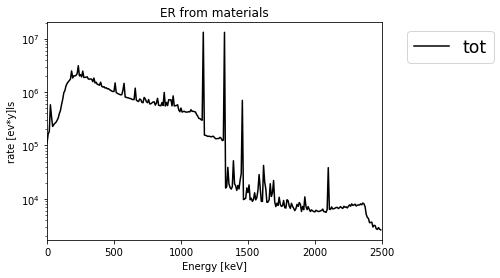

In [21]:
plot = plt.plot(bins_plt[:-1], values, "black", label = "tot")
plt.legend(markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-large')
plt.yscale("log")
lim= 2500
plt.xlim(0,lim)
plt.ylabel("rate [ev*y]ls")

plt.xlabel("Energy [keV]")
plt.title("ER from materials")
plt.savefig('%s.png'%lim, bbox_inches='tight')
plt.show() 

In [ ]:
savefig('%s.png'%lim, bbox_inches='tight')

In [34]:
import pickle
import matplotlib.pyplot as plt
pickle.dump(plot, open("plot.pickle.p", "wb"), fix_imports=True)

 


In [36]:
b = pickle.load(open("plot.pickle.p", "rb"))
b.show()

AttributeError: 'list' object has no attribute 'show'

In [33]:
print(b)

In [ ]:
components = ["OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "OuterCryostatReflector",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "PmtTpc",
              "Copper_TopRing",
              "Copper_LowerRing",
              "Teflon_Pillar_",
              "SS_Electrodes",
              "Teflon_BottomTPC",
              "Teflon_TPC_Sliding",
              "Teflon_TPC_Fixed",
              "Copper_FieldGuard_",
              "Copper_FieldShaperRing_",
              "Top_PTFE_Frame",
              "Copper_BottomPmtPlate",
             "Copper_TopPmtPlate"]

DATE = 'XENONnT_2019-11-19'
DATE = "XENONnT_20191202"
isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226"
                ]
def only_cont(component, m_fv): 
    p = get_parameters(component)
    screen_id = (p["ids"])
    total_str = ("|%s" %screen_id)
    for i in range(0, len(isotope_array)):
        isotope = isotope_array[i]
        
        mass = p['mass']
        contamination = p[isotope] 
        err = "err_"+isotope
        err = str(err)
        error_cont = p[err]
        contamination = p[isotope]
        if (contamination == 0):
            str_ = ("|<color #ed1c24>no contamination value</color>")
        else:
            str_ = ("|%2.2f  +- %2.2f" %(contamination, error_cont))
        total_str = total_str  + str_ 
               
    print("|" + component + total_str + "|")

def print_cont(m_fv):
    print("^material ^ screening_id ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
             isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^", )
    for component in components:
        only_cont(component, m_fv)

print_cont(m_fv)     